In [0]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [10]:
print(__doc__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

2019-03-09 10:14:44,265 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-03-09 10:14:50,351 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-03-09 10:14:51,290 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-03-09 10:14:52,434 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [11]:
n_components = 150

print("Extracting %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("pca")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting 150 eigenfaces from 966 faces
done in 0.315s
pca
done in 0.045s


In [12]:
print("Fitting")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator:")
print(clf.best_estimator_)

Fitting


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 31.712s
Best estimator:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [13]:
print("Predicting")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting
done in 0.079s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.85      0.97      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.97      0.78      0.86        36

        micro avg       0.85      0.85      0.85       322
        macro avg       0.87      0.73      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  1  52   1   5   0   1   0]
 [  1   3  18   5   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]
 [  0   1   1   6   0   0  28]]


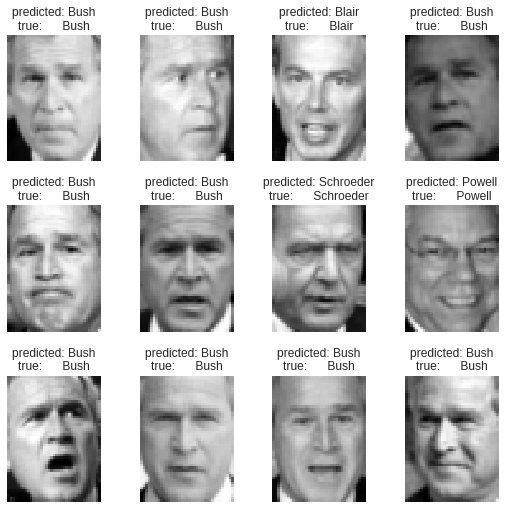

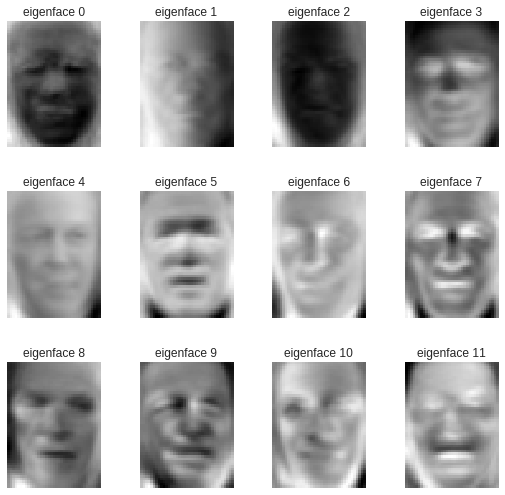

In [15]:
def draww(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

draww(X_test, prediction_titles, h, w)
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
draww(eigenfaces, eigenface_titles, h, w)

plt.show()